###  导入模块

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F 
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt

### 定义编码器

In [2]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

### 定义解码器

In [3]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

### 定义VAE

In [4]:
class VAE(torch.nn.Module):
    latent_dim = 8  # 隐变量维度

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # 编码器到均值和log方差的两个网络, 且默认知道编码器的最后一层维度为100, 隐变量维度为8
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * std_z  # Reparameterization trick
    
    
    def forward(self, state):
        h_enc = self.encoder(state)  # 编码器的输出
        z = self._sample_latent(h_enc)
        return self.decoder(z)

### 计算KL散度误差项

In [5]:
# 计算KL散度误差项
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

Number of samples:  60000
0 0.07134895771741867
1 0.06250201910734177
2 0.07147786021232605
3 0.06432824581861496
4 0.06242973357439041
5 0.06560368835926056
6 0.06614285707473755
7 0.07027167081832886
8 0.06962623447179794
9 0.0656011551618576
10 0.06550559401512146
11 0.06820596009492874
12 0.06393261253833771
13 0.06882257014513016
14 0.06708746403455734
15 0.0640035942196846
16 0.06641925126314163
17 0.06491492688655853
18 0.06631259620189667
19 0.06409668177366257
20 0.07062452286481857
21 0.06658756732940674
22 0.06735407561063766
23 0.06352271884679794
24 0.06419023126363754
25 0.0674062967300415
26 0.06671597808599472
27 0.07069134712219238
28 0.07186707109212875
29 0.0706745907664299
30 0.06385093927383423
31 0.061521705240011215
32 0.06785331666469574
33 0.0714964047074318
34 0.06357137858867645
35 0.06244207173585892
36 0.06802600622177124
37 0.06563977152109146
38 0.06497756391763687
39 0.0698019489645958
40 0.07012210786342621
41 0.066471166908741
42 0.07034033536911011
43

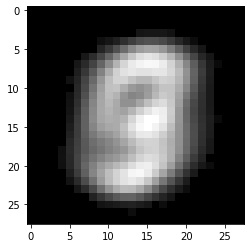

In [6]:
input_dim = 28 * 28
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

print('Number of samples: ', len(mnist))

encoder = Encoder(input_dim, 100, 100)  # 隐藏层维度为100, 输出维度为100
decoder = Decoder(8, 100, input_dim)  # 隐藏层维度为100
vae = VAE(encoder, decoder)

criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.0001)
l = None
for epoch in range(100):
    for i, data in enumerate(dataloader, 0):
        inputs, classes = data
        inputs.resize_(batch_size, input_dim)
        optimizer.zero_grad()
        dec = vae(inputs)  # 获得的输出端解码
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll  # 重建误差 + KL散度误差
        loss.backward()
        optimizer.step()
        l = loss.item()
        # l = loss.data[0]
        """
        考虑在 PyTorch0.4.0 版本之前广泛使用的 total_loss + = loss.data [0] 模式
        Loss 是一个包含张量(1, )的Variable, 但是在新发布的 0.4.0 版本中. loss 是一个0维标量, 对于标量的索引是没有意义的
        使用 loss.item（）从标量中获取 Python 数字
        """
    print(epoch, l)

plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)